In [1]:
import pandas as pd

# Load the final merged hourly dataset
merged_data = pd.read_parquet('../datasets/final_merged_dataset_hourly.parquet')

# Confirm it's loaded properly
print(merged_data.head())
print(f"Total data points: {len(merged_data)}")


             datetime      Open      High       Low     Close    Volume  \
0 2021-01-01 00:00:00  0.250730  0.251106  0.250628  0.250493  0.076344   
1 2021-01-01 01:00:00  0.251433  0.251695  0.251353  0.251520  0.015258   
2 2021-01-01 02:00:00  0.256154  0.256011  0.255263  0.255877  0.034476   
3 2021-01-01 03:00:00  0.252147  0.252928  0.252351  0.253123  0.010795   
4 2021-01-01 04:00:00  0.254932  0.255284  0.254180  0.254066  0.023016   

   sentiment_score  bert_sentiment  prev_close  prev_vader_sentiment  \
0              0.0             0.0    0.250493                   0.0   
1              0.0             0.0    0.250493                   0.0   
2              0.0             0.0    0.251520                   0.0   
3              0.0             0.0    0.255877                   0.0   
4              0.0             0.0    0.253123                   0.0   

   prev_bert_sentiment  volatility_7d  volatility_14d  volatility_30d  \
0                  0.0       0.050683      

In [2]:
# Step 2: Feature Selection (no scaling needed)

# Select price features
price_features = ['Open', 'High', 'Low', 'Close', 'Volume']
price_data = merged_data[price_features].values

# Select sentiment features
sentiment_features = ['sentiment_score', 'bert_sentiment']
sentiment_data = merged_data[sentiment_features].values

print(f"Price data shape: {price_data.shape}")
print(f"Sentiment data shape: {sentiment_data.shape}")


Price data shape: (18265, 5)
Sentiment data shape: (18265, 2)


In [3]:
import numpy as np

# Define window size (how many past hours to look at)
window_size = 24

# Empty lists to store sequences
X_price = []
X_sentiment = []
y_target = []

# Loop to create sliding windows
for i in range(window_size, len(price_data)):
    # Past 24 hours price features
    X_price.append(price_data[i - window_size:i])

    # Past 24 hours sentiment features
    X_sentiment.append(sentiment_data[i - window_size:i])

    # Predict next hour's Close price
    y_target.append(price_data[i, 3])  # 3 -> 'Close' column

# Convert to arrays
X_price = np.array(X_price)
X_sentiment = np.array(X_sentiment)
y_target = np.array(y_target)

print(f"X_price shape: {X_price.shape}")
print(f"X_sentiment shape: {X_sentiment.shape}")
print(f"y_target shape: {y_target.shape}")


X_price shape: (18241, 24, 5)
X_sentiment shape: (18241, 24, 2)
y_target shape: (18241,)


In [4]:
# Define train-test split percentage
train_size = int(0.8 * len(X_price))  # 80% for training, 20% for testing

# Training set
X_price_train = X_price[:train_size]
X_sentiment_train = X_sentiment[:train_size]
y_train = y_target[:train_size]

# Testing set
X_price_test = X_price[train_size:]
X_sentiment_test = X_sentiment[train_size:]
y_test = y_target[train_size:]

# Shapes confirmation
print(f"Training samples: {X_price_train.shape[0]}")
print(f"Testing samples: {X_price_test.shape[0]}")


Training samples: 14592
Testing samples: 3649


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate

# Step 5.1: Price Input Stream
price_input = Input(shape=(X_price_train.shape[1], X_price_train.shape[2]), name="price_input")
x = LSTM(64, return_sequences=False)(price_input)
x = Dropout(0.2)(x)

# Step 5.2: Sentiment Input Stream
sentiment_input = Input(shape=(X_sentiment_train.shape[1],), name="sentiment_input")
y = Dense(32, activation="relu")(sentiment_input)

# Step 5.3: Merge Price + Sentiment Streams
combined = concatenate([x, y])
z = Dense(32, activation="relu")(combined)
output = Dense(1)(z)  # Final prediction

# Step 5.4: Create the Model
sentiment_enhanced_lstm = Model(inputs=[price_input, sentiment_input], outputs=output)

# Step 5.5: Compile the Model
sentiment_enhanced_lstm.compile(optimizer="adam", loss="mse")

# Summary
sentiment_enhanced_lstm.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 24, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,920 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_input     │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        800 │ sentiment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      3,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,857 (85.38 KB)

 Trainable params: 21,857 (85.38 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
X_sentiment_train = X_sentiment_train[:, :, 0]  # use VADER
X_sentiment_test = X_sentiment_test[:, :, 0]

# Train the model
history = sentiment_enhanced_lstm.fit(
    [X_price_train, X_sentiment_train],
    y_train,
    validation_data=([X_price_test, X_sentiment_test], y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0393 - val_loss: 9.3740e-05
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 8.8788e-05
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 8.5772e-05
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8371e-04 - val_loss: 7.0318e-05
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2948e-04 - val_loss: 1.1244e-04
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4826e-04 - val_loss: 9.1997e-05
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5022e-04 - val_loss: 6.5795e-05
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3883e-04 - val_loss: 4.1749e-05
Epoch 9/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4255e-04 - val_loss: 8.3867e-05
Epoch 10/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9270e-04 - val_loss: 9.8020e-05
Epoch 11/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6723e-04

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Step 7.1: Predict on test set
y_pred = sentiment_enhanced_lstm.predict([X_price_test, X_sentiment_test])

# Step 7.2: Flatten predictions (if needed)
y_pred = y_pred.flatten()

# Step 7.3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Step 7.4: Calculate Safe MAPE
threshold = 0.01  # avoid very tiny values
mask = np.abs(y_test) > threshold
mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100

# Step 7.5: Print evaluation
print(f"✅ RMSE: {rmse:.6f}")
print(f"✅ Safe MAPE: {mape:.2f}%")


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ RMSE: 0.009507
✅ Safe MAPE: 27.19%


In [8]:
import sys
sys.path.append("../src")

from metric_logging import log_experiment

In [ ]:


# Define parameters
params = {
    "architecture": "Sentiment-Enhanced LSTM",
    "input_features": "price + sentiment",
    "sequence_length": 24,
    "units": 64,
    "dropout_rate": 0.2,
    "optimizer": "Adam",
    "loss": "MSE",
    "epochs": 20,
    "batch_size": 64
}

# Define metrics
metrics = {
    "RMSE": rmse,
    "Safe_MAPE": mape
}

# Log the model
log_experiment(
    model_name="Sentiment_Enhanced_LSTM-advanced",
    model_object=sentiment_enhanced_lstm,
    params=params,
    metrics=metrics
)


In [10]:
import numpy as np

# -------------------------------------------------------------------
# 1)  Work with numpy copies of your current test arrays
#      X_price_test  :  (samples, 24, 5)
#      X_sentiment_test : (samples, 24)   ➊ already single‑feature (VADER)
# -------------------------------------------------------------------
price_np     = X_price_test.copy()
sent_np      = X_sentiment_test.copy()

# -------------------------------------------------------------------
# 2)  Feature‑wise noise level   (2 % of each feature’s range)
# -------------------------------------------------------------------
price_range  = price_np.max(axis=(0, 1)) - price_np.min(axis=(0, 1))
price_noise  = 0.02 * price_range          # σ per price feature

sent_range   = sent_np.max() - sent_np.min()
sent_noise   = 0.02 * sent_range           # single σ for sentiment

# -------------------------------------------------------------------
# 3)  Add Gaussian noise
# -------------------------------------------------------------------
price_np_noisy = price_np + np.random.normal(0.0, price_noise, price_np.shape)
sent_np_noisy  = sent_np  + np.random.normal(0.0, sent_noise,  sent_np.shape)

#  (optional) clip to original min/max to avoid wild outliers
price_np_noisy = np.clip(price_np_noisy, price_np.min(), price_np.max())
sent_np_noisy  = np.clip(sent_np_noisy,  sent_np.min(),  sent_np.max())

print("✅  Noisy test‑sets created:",
      price_np_noisy.shape, sent_np_noisy.shape)

✅  Noisy test‑sets created: (3649, 24, 5) (3649, 24)


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1‑A  Clean predictions
y_pred_clean = sentiment_enhanced_lstm.predict(
    [X_price_test, X_sentiment_test], verbose=0).flatten()

rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_clean))

mask       = np.abs(y_test) > 0.01
mape_clean = mean_absolute_percentage_error(
                y_test[mask], y_pred_clean[mask]) * 100

# 1‑B  Noisy predictions
y_pred_noisy = sentiment_enhanced_lstm.predict(
    [price_np_noisy, sent_np_noisy], verbose=0).flatten()

rmse_noisy = np.sqrt(mean_squared_error(y_test, y_pred_noisy))
mape_noisy = mean_absolute_percentage_error(
                y_test[mask], y_pred_noisy[mask]) * 100

# 2   Report robustness
def pct_inc(a, b):
    return (b - a) / a * 100

print("\n🔎  Sentiment‑LSTM — OOD Noise Robustness")
print("------------------------------------------")
print(f"Clean  RMSE       : {rmse_clean:.6f}")
print(f"Noisy  RMSE       : {rmse_noisy:.6f} "
      f"({pct_inc(rmse_clean, rmse_noisy):+.1f} %)")

print(f"\nClean  Safe MAPE  : {mape_clean:.2f}%")
print(f"Noisy  Safe MAPE  : {mape_noisy:.2f}% "
      f"({pct_inc(mape_clean, mape_noisy):+.1f} %)")


🔎  Sentiment‑LSTM — OOD Noise Robustness
------------------------------------------
Clean  RMSE       : 0.009507
Noisy  RMSE       : 0.009851 (+3.6 %)

Clean  Safe MAPE  : 27.19%
Noisy  Safe MAPE  : 27.88% (+2.5 %)


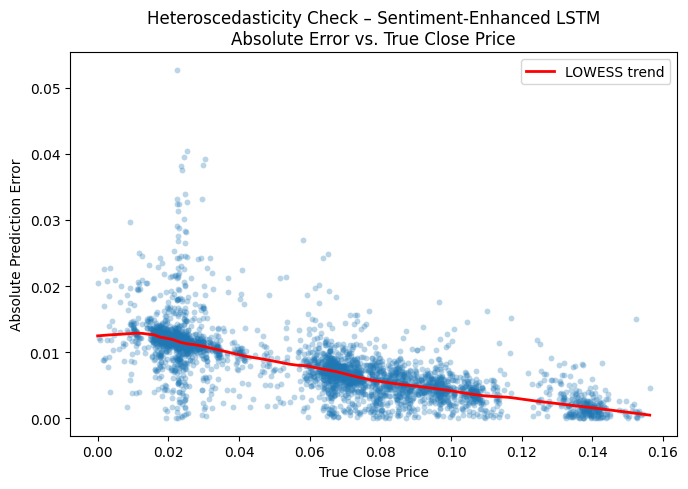

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

# ---------------------------------------------------------------
# 1)  Clean predictions for Sentiment‑LSTM
#     (re‑compute in case you overwrote y_pred earlier)
# ---------------------------------------------------------------
y_pred_sent_clean = sentiment_enhanced_lstm.predict(
    [X_price_test, X_sentiment_test], verbose=0).flatten()

# Absolute errors
abs_errors_sent = np.abs(y_test - y_pred_sent_clean)

# DataFrame for ease of plotting
df_plot_sent = pd.DataFrame({
    "TrueClose": y_test,
    "AbsError" : abs_errors_sent
})

# ---------------------------------------------------------------
# 2)  LOWESS smoothing curve
# ---------------------------------------------------------------
lowess_curve_sent = lowess(df_plot_sent["AbsError"],
                           df_plot_sent["TrueClose"],
                           frac=0.15, return_sorted=True)

# ---------------------------------------------------------------
# 3)  Plot
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot_sent,
                x="TrueClose", y="AbsError",
                alpha=0.3, s=18, linewidth=0)

plt.plot(lowess_curve_sent[:,0], lowess_curve_sent[:,1],
         color="red", linewidth=2, label="LOWESS trend")

plt.title("Heteroscedasticity Check – Sentiment‑Enhanced LSTM\nAbsolute Error vs. True Close Price")
plt.xlabel("True Close Price")
plt.ylabel("Absolute Prediction Error")
plt.legend()
plt.tight_layout()
plt.show()

  5%  | RMSE = 0.071172 | Safe MAPE = 187.54%
 10%  | RMSE = 0.068518 | Safe MAPE = 186.34%
 20%  | RMSE = 0.058739 | Safe MAPE = 162.53%
 40%  | RMSE = 0.114169 | Safe MAPE = 331.84%
 60%  | RMSE = 0.018152 | Safe MAPE =  46.14%
 80%  | RMSE = 0.037763 | Safe MAPE = 108.72%
100%  | RMSE = 0.053525 | Safe MAPE = 157.18%


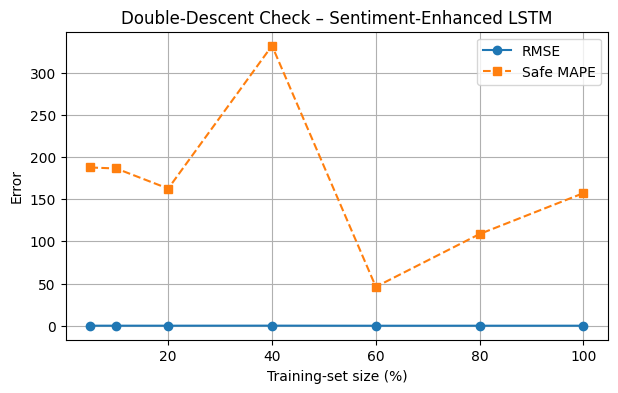

In [14]:
# ===============================================
# Corrected Double‑Descent experiment 
# for *Sentiment‑Enhanced LSTM* (Matching Safe MAPE)
# ===============================================
import numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# -- 0. Helper: fresh model builder ----------------------
def build_sentiment_lstm(price_shape, senti_shape):
    p_in  = tf.keras.Input(price_shape)
    x     = tf.keras.layers.LSTM(64)(p_in)
    x     = tf.keras.layers.Dropout(0.2)(x)

    s_in  = tf.keras.Input(senti_shape)
    y     = tf.keras.layers.Dense(32, activation='relu')(s_in)

    combined = tf.keras.layers.Concatenate()([x, y])
    z = tf.keras.layers.Dense(32, activation='relu')(combined)
    output = tf.keras.layers.Dense(1)(z)

    model = tf.keras.Model(inputs=[p_in, s_in], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# -- 1.  Fractions of training set to try
fractions = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

rmse_curve, safe_mape_curve = [], []

for frac in fractions:
    # --- 1‑a.  Chronological subsample -------------------
    n = int(frac * len(X_price_train))
    X_price_sub = X_price_train[:n]
    X_senti_sub = X_sentiment_train[:n]
    y_sub       = y_train[:n]
    
    # --- 1‑b.  Fresh Model each pass ----------------------
    tf.keras.backend.clear_session()
    model = build_sentiment_lstm(
        price_shape=(X_price_sub.shape[1], X_price_sub.shape[2]),
        senti_shape=(X_senti_sub.shape[1],)
    )
    
    model.fit(
        [X_price_sub, X_senti_sub], y_sub,
        epochs=20, batch_size=64,
        validation_split=0.2, verbose=0
    )
    
    # --- 1‑c.  Predict on fixed Test Set -------------------
    y_pred = model.predict([X_price_test, X_sentiment_test], verbose=0).flatten()

    # --- 1‑d.  Compute RMSE + Safe MAPE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mask = np.abs(y_test) > 0.01  # Safe-MAPE threshold
    safe_mape = mean_absolute_percentage_error(
        y_test[mask], y_pred[mask]
    ) * 100
    
    rmse_curve.append(rmse)
    safe_mape_curve.append(safe_mape)
    
    print(f"{int(frac*100):>3}%  | RMSE = {rmse:.6f} | Safe MAPE = {safe_mape:6.2f}%")

# -- 2.  Plot ------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(np.array(fractions)*100, rmse_curve, 'o-', label='RMSE')
plt.plot(np.array(fractions)*100, safe_mape_curve, 's--', label='Safe MAPE')
plt.xlabel('Training‑set size (%)')
plt.ylabel('Error')
plt.title('Double‑Descent Check – Sentiment‑Enhanced LSTM')
plt.grid(True); plt.legend(); plt.show()